In [28]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy as sc
import nibabel as nib
import os
import scipy.integrate as integrate
#from sklearn.neighbors import KernelDensity
from scipy.fft import fft, ifft
from scipy.interpolate import Rbf
import scipy.stats as stats
import SimpleITK as sitk

# Read in images

In [67]:
slice = 160

cmap='gray'

filepath = "segmentation_data/"

data_t1 = os.path.join(filepath, "996782_3T_T1w_MPR1.nii")
data_t2 = os.path.join(filepath, "996782_3T_T2w_SPC1.nii")

#fig, axs = plt.subplots(1,2, figsize=(8,3), sharex=True, sharey=True)
#axs[0].imshow(data_t1[:,:,slice], cmap=cmap)
#axs[1].imshow(data_t2[:,:,slice], cmap=cmap)
#plt.show()


# N3 Algorithm for Bias field estimation

In [ ]:
def B_times_I(i, j, B, I, times_i):
    """ Set up integrand """
    if times_i:
        return i*B(j-i)*I[i]
    else:
        return B(j-i)*I[i]
    
def B(x, mu=0, sigma=0.01):
    return stats.norm.pdf(x, mu, sigma)

def N3(img, Bhat, eps=0.1, Z=0.01, num_anchor_points=15):
    b = 0
    j = np.ln(img)
    Fhat = fft(B) / (abs(Bhat)**2 + Z**2)
    xn = np.rand(np.size(img), num_anchor_points, replace=False) # generate random anchor points
    x_anchors, y_anchors = np.unravel_index(xn, j.shape) # unflatten index to x and y values of anchor points
    
    while np.norm(delta_b) < eps:
        J = np.histogram(np.flatten(j), bins=50, density=True) # estimate J(j) with kernel density est. or histogram 
        jx = J[1] # intensity values (x axis values in density plot)
        Bhat = fft(B(J[1]))
        Fhat = np.conj(Bhat)) / (np.abs(Bhat)**2 + Z**2)
        I = ifft(Fhat * fft(J))
        for i,(x,y) in enumerate(zip(x_anchors, y_anchors)):
            delta_b_e[i] = j[x,y] - integrate.simpsons(I)[0] / integrate.quad(B_times_I, -np.inf, +np.inf, args=(j[x,y], B, I, False))[0]
        delta_b = Rbf(x=x_anchors, y=y_anchors, d=delta_b_e)(np.linspace(0, j.shape[0]), np.linspace(0, j.shape[1]))
        b += delta_b
        j -= delta_b

In [9]:
imgs = []
corrimgs = []
biasfield = []
for data in [data_t1, data_t2]:    
    inputImage = sitk.ReadImage(data, sitk.sitkFloat32)
    image = inputImage[:,:,slice]
    imgs.append(sitk.GetArrayFromImage(image))
    maskImage = sitk.OtsuThreshold(image, 0, 1, 200)
    corrector = sitk.N4BiasFieldCorrectionImageFilter()
    corrimgs.append(sitk.GetArrayFromImage(corrector.Execute(image, maskImage)))
    biasfield.append(sitk.GetArrayFromImage(corrector.GetLogBiasFieldAsImage(image)))
#corrected_image_full_resolution = inputImage / sitk.Exp(log_bias_field)

In [13]:
# Plot bias field corrected image
fig, axs = plt.subplots(2,4, figsize=(10,6))
for i, (img, corr, bias) in enumerate(zip(imgs, corrimgs, biasfield)):
    axs[i,0].imshow(img, cmap=cmap)
    axs[i,1].imshow(corr, cmap=cmap)
    axs[i,2].imshow(bias, cmap=cmap)
    axs[i,3].hist(corr.flatten(), bins=50)
plt.show()
plt.tight_layout()

<IPython.core.display.Javascript object>

# Segmentation

In [37]:
from PIL import Image
# Open the image form working directory
image = Image.open(os.path.join(filepath, 'skullstripped_high.png'))
img = np.array(image)[:,:,2]
img[img==0] = 1

img = sc.ndimage.gaussian_filter(img, sigma=.5)

#img = corrimgs[1][33:270, 60:190] # zoom in to get rid of skull

def logsumexp(x, mu, Sigma, pi):
    """ Perform logsumexp trick to prevent over/underflow.
        This algorithm computes the log probabilities of x given
        normal distribution with parameters mu and Sigma, and
        multiplies this with the p(c(x)|mu, Sigma) for each c in {1,...,C}.
        More info: https://leimao.github.io/blog/LogSumExp/ """
    
    C = mu.shape[0] # number of categories
    N = x.shape[0] # number of pixels
    trick = np.zeros((N, C)) # NxC
    for c in range(C):
        exponent = -1.0 / (2*Sigma[c]) * np.power(np.subtract(x, mu[c]), 2) # exponent of normal dist
        const = -0.5 * np.log(2*np.pi*Sigma[c]) # const of normal dist
        logsum = np.sum(const + exponent, axis=1)
        trick[:, c] = np.log(pi[c]) + logsum
    m = trick.max(axis=1) # find max value for later subtraction
    m = m.reshape((m.shape[0], 1)) # Nx1
    return trick, m

def update_P_C_given_I(trick, m):
    """E-step update"""
    trick = trick - m
    numer = np.exp(trick) # NxC
    denom = np.sum(numer, axis=1) # Nx1
    denom = denom.reshape((denom.shape[0], 1)) #?
    return np.divide(numer, denom) # NxC

def update_pi(P):
    N = P.shape[0] # number of pixels
    px_sum = np.sum(P, axis=0) # Cx1 
    return np.divide(px_sum, N) # Cx1

def update_mu(P, x):
    numer = np.dot(np.transpose(P), x) # (CxN)*(NxD) -> CxD
    denom = np.sum(P, axis=0) # 1xC
    denom = denom.reshape((denom.shape[0], 1)) # Cx1
    res = np.divide(numer, denom)
    return res # CxD

def update_Sigma(P, mu, x):
    D = x.shape[1] # number of dimensions (RGB case)
    C = mu.shape[0] # number of categories
    numer = np.zeros((C,1)) # Cx1
    for c in range(C):
        P_c = P[:, c] # Nx1
        P_c = P_c.reshape((P_c.shape[0], 1))
        sub = np.subtract(x, mu[c]) # NxD
        # Nx1 .* NxD -> NxD -> sum row wise -> Dx1 -> sum -> 1x1
        res = np.sum(np.sum(np.multiply(np.power(sub, 2), P_c), axis=1))
        numer[c] = res
    
    denom = D * np.sum(P, axis=0) # Cx1, sum up probs over all channels D (same over all channels hence * D)
    denom = denom.reshape((C, 1)) 
    
    return np.divide(numer, denom)
        
    
def update_loglikehood(trick, m):
    trick -= m # NxC
    p = np.log(np.sum(np.exp(trick), axis=1))
    p = p.reshape((p.shape[0], 1)) + m # Nx1
    return np.sum(p, axis=0) #1x1


def init_parameters(D, C):
    mu = np.random.rand(C, D)
    Sigma = np.random.uniform(low=0.1, high=1, size=C)    # Cx1
    val = 1/C
    pi = np.full(C, val)  # Cx1
    return mu, Sigma, pi


def EM(x, C, tol=1e-6):
    
    D = x.shape[1]
    mu, Sigma, pi = init_parameters(D, C)
    
    t, m = logsumexp(x, mu, Sigma, pi)
    p = update_loglikehood(t, m)
    
    counter = 0
    
    while counter < 999:
        if counter % 50 == 0: print(f"Iteration: {counter, mu.max()}")
        
        # E-step
        P = update_P_C_given_I(t, m)
        
        # M-step
        pi = update_pi(P)
        mu = update_mu(P, x)
        Sigma = update_Sigma(P, mu, x)
        
        p_old = p
        
        t, m = logsumexp(x, mu, Sigma, pi)
        p = update_loglikehood(t, m)
        
        if p - p_old < 0:
            print("Error found, likelihood update gone wrong!")
            
        if abs(p - p_old) < tol:
            print("Convergence criterion met")
            print('Total iterations: ', counter)
            return P, mu, Sigma, pi
        
        counter += 1
        
    return P, mu, Sigma, pi
        
    
img_flat = img.reshape((img.shape[0]*img.shape[1], 1)) / img.max()
C = 4
P, mu, Sigma, pis = EM(img_flat, C=C)

Iteration: (0, 0.8001902573851896)
Iteration: (50, 0.7361418867506958)
Iteration: (100, 0.8322455738065216)
Iteration: (150, 0.83692707848862)
Iteration: (200, 0.8369504784183881)
Convergence criterion met
Total iterations:  210


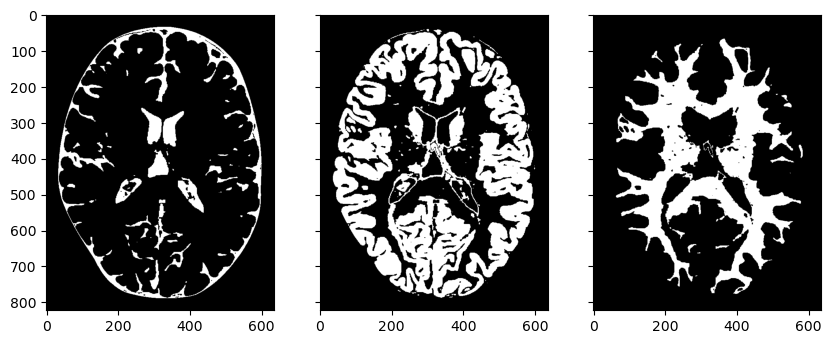

<Figure size 640x480 with 0 Axes>

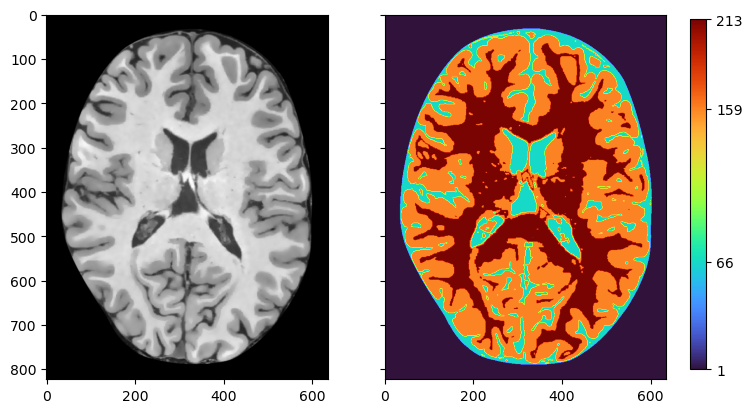

In [38]:
def output_segmentation(mu, P, x_shape, C):
    """Given EM segmentation, plot image"""
    mu = mu * 255
    mu = mu.astype(np.uint8)
    max_likelihood = np.argmax(P, axis=1) # 1xN
    means_of_data = np.array([mu[i] for i in max_likelihood])  # NxD
    means_of_data = means_of_data.astype(np.uint8)
    means_of_data = means_of_data.reshape(x_shape)
    fig, axs = plt.subplots(1,C-1, sharex=True, sharey=True, figsize=(10,5))
    unique = np.unique(means_of_data)[1:]
    for val, ax in zip(unique, axs):
        if val==1: continue
        temp = np.copy(means_of_data)
        temp[temp!=val] = 0
        ax.imshow(temp, cmap='gray')
    plt.show()
    plt.tight_layout()
    
def plot_segmentation(mu, P, x_shape):    
    mu = mu * 255
    mu = mu.astype(np.uint8)
    max_likelihood = np.argmax(P, axis=1) # 1xN
    means_of_data = np.array([mu[i] for i in max_likelihood])  # NxD
    means_of_data = means_of_data.astype(np.uint8)
    means_of_data = means_of_data.reshape(x_shape)
    fig, axs = plt.subplots(1,2, sharex=True, sharey=True,figsize=(8,5))
    axs[0].imshow(img, cmap='gray')
    segm = axs[1].imshow(means_of_data, cmap='turbo')
    cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
    fig.colorbar(segm, cax=cbar_ax, ticks=np.unique(means_of_data))
    #plt.tight_layout()
    
output_segmentation(mu, P, x_shape=img.shape, C=C)
plot_segmentation(mu, P, x_shape=img.shape)

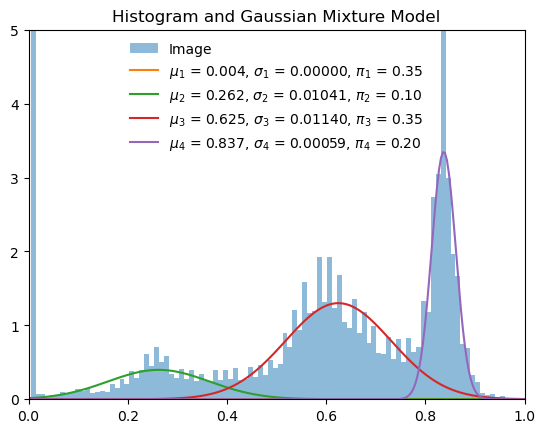

In [66]:
# Plot fitted Gaussians and histogram

x = np.linspace(0, 1, num=250)
#fit = np.sum(np.array([pi*sc.stats.norm.pdf(x, mu, sigma) for (mu, sigma, pi) in zip(mu, Sigma, pi)]),axis=0)
#fit = fit.reshape(fit.shape[0],1)
mus = mu.flatten()
order = np.argsort(mus)
mus = [mus[i] for i in order]
Sigmas = [Sigma.flatten()[i] for i in order]
piss = [pis.flatten()[i] for i in order]

fig, ax = plt.subplots(1,1)
ax.hist(img.flatten()/img.max(), density=True, bins=100, label='Image', alpha=0.5)
for i,(m, sigma, pi) in enumerate(zip(mus, Sigmas, piss),1):
    fit = pi * sc.stats.multivariate_normal.pdf(x, mean=m, cov=sigma)
    ax.plot(x, fit, label=f'$\mu_{i}$ = {float(m):.3f}, $\sigma_{i}$ = {float(sigma):.5f}, $\pi_{i}$ = {pi:.2f}')
plt.xlim([0.,1])
plt.ylim([0, 5])
plt.title('Histogram and Gaussian Mixture Model')
plt.legend(loc='best', frameon=False)
plt.show()
